In [1]:
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from open3d import JVisualizer

import torch
import torch.nn as nn

%matplotlib nbagg

In [2]:
PROJECT_DIR = os.path.realpath('../')
if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

In [3]:
from networks import occant
from configs import get_cfg_defaults
from networks.occant_baselines.depthsensor import DepthProjector

In [4]:
cfg = get_cfg_defaults()

In [5]:
cfg.GP_ANTICIPATION

CfgNode({'type': 'occant_rgb', 'unet_nsf': 16, 'freeze_features': False, 'nclasses': 2, 'resnet_type': 'resnet18', 'detach_depth_proj': False, 'pretrained_depth_proj_model': '', 'freeze_depth_proj_model': False, 'OUTPUT_NORMALIZATION': CfgNode({'channel_0': 'identity', 'channel_1': 'identity'}), 'wall_fov': 120.0})

<IPython.core.display.Javascript object>


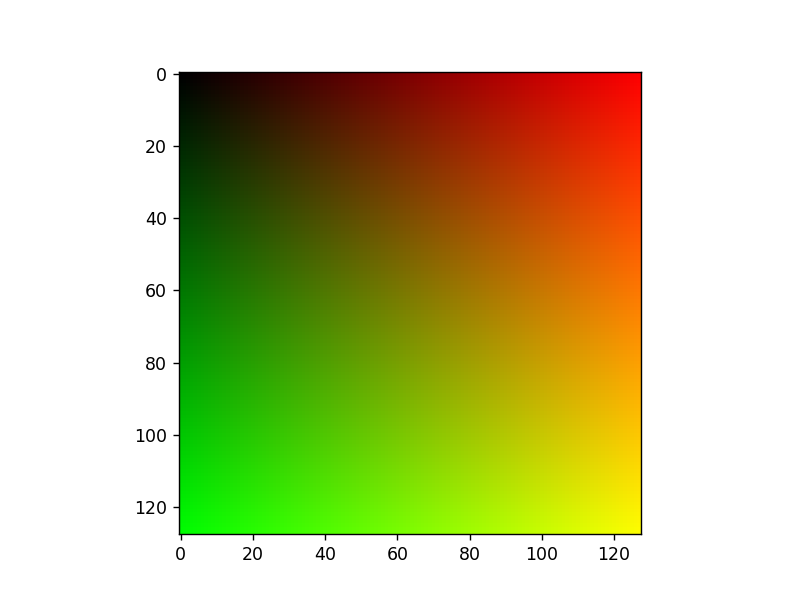

In [6]:
def set_pix_coords(opt):
    meshgrid = np.meshgrid(range(opt.width), range(opt.height), indexing='xy')
    id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
    id_coords = nn.Parameter(torch.from_numpy(id_coords), requires_grad=False)

    ones = nn.Parameter(torch.ones(1, 1, opt.height * opt.width), requires_grad=False)

    pix_coords = torch.unsqueeze(torch.stack([id_coords[0].view(-1), id_coords[1].view(-1)], 0), 0)
    pix_coords = nn.Parameter(torch.cat([pix_coords, ones], 1), requires_grad=False)
    return pix_coords

pix_coords = set_pix_coords(cfg)
pix_coords = pix_coords.squeeze().reshape(3, cfg.height, cfg.width).cpu().detach().numpy()
plt.imshow(pix_coords.transpose(1,2,0)/128)

In [7]:
K = np.array([[cfg.focal_length, 0, 64, 0],
           [0, cfg.focal_length, 64, 0],
           [0, 0, 1, 0],
           [0, 0, 0, 1]], dtype=np.float32)

inv_K = np.linalg.inv(K)

cam_coords = (inv_K[:3, :3] @ pix_coords.reshape(3, -1)).reshape(*pix_coords.shape)

In [8]:
depth_projector = DepthProjector(cfg)

0.0 6.4154577


<IPython.core.display.Javascript object>


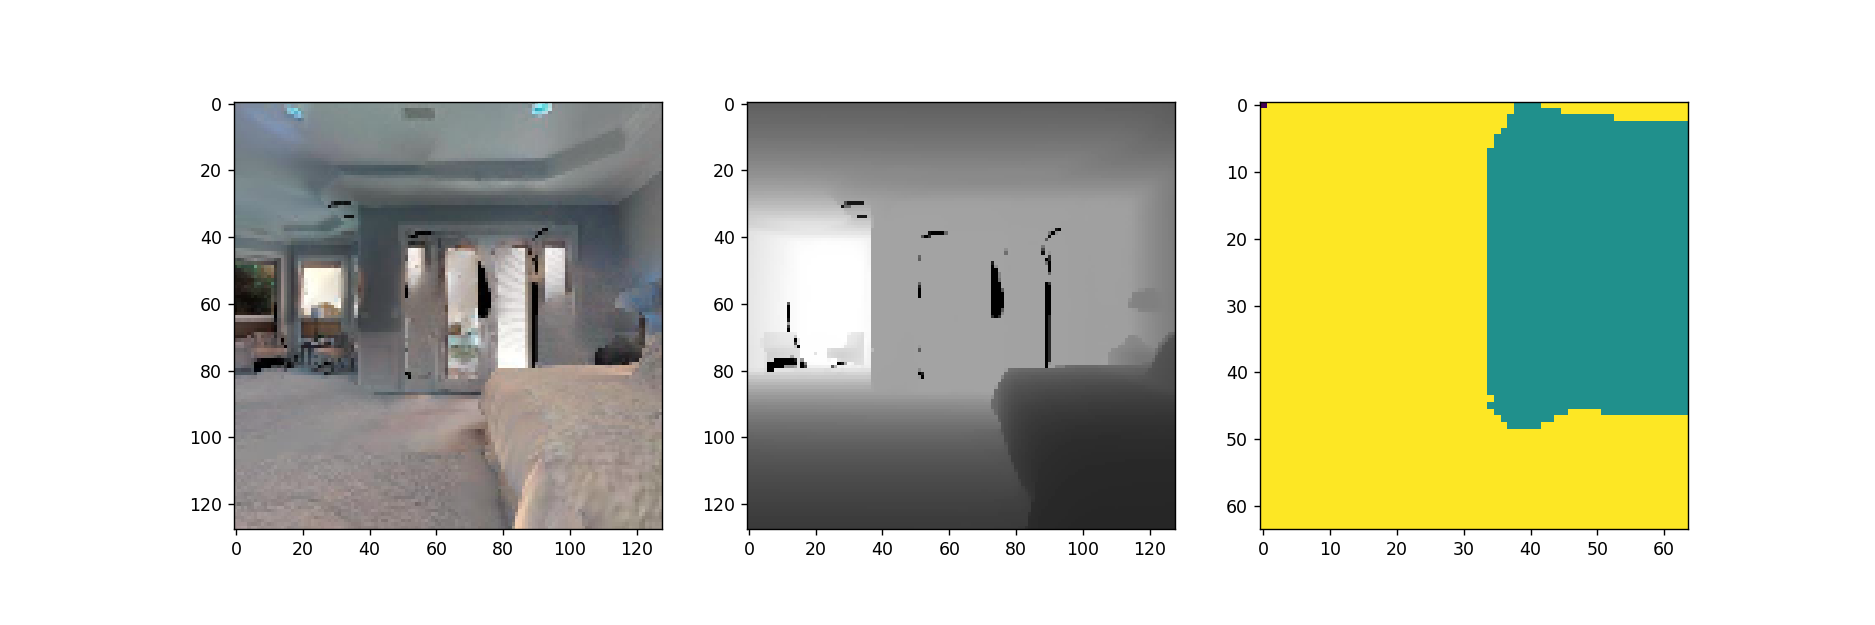

In [12]:
scene = 'Lindenwood'
# idx = 2590  
# idx = 2535
idx = 2600
flip = False

if not flip:
    rgb = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/left_rgb/{idx}.jpg', -1)
    depth = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/left_depth/{idx}.png', -1).astype(np.float32) /6553.5
    bev_sim = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/sim/{scene}/0/bev/{idx}.png', -1)
else:
    rgb = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/right_rgb/{idx}.jpg', -1)
    depth = cv2.imread(f'/scratch/shantanu/HabitatGibson/data/{scene}/0/right_depth/{idx}.png', -1).astype(np.float32) /6553.5
    bev_sim = cv2.imread(f'/scratch/shantanu/HabitatGibson/bevs/sim/{scene}/0/bev/{idx}.png', -1)
    
    rgb = cv2.flip(rgb, 1)
    depth = cv2.flip(depth, 1)
    bev_sim = cv2.flip(bev_sim, 1)

# rgb = cv2.cvtColor(cv2.imread(f'/scratch/shantanu/img.png', -1), cv2.COLOR_BGR2RGB)
# bev_sim = cv2.imread('/scratch/shantanu/bev.png', -1)
# depth = cv2.imread('/scratch/shantanu/depth.png', -1).astype(np.float32) /6553.5
    
rgb = cv2.resize(rgb, (170, 128))[:, 21:149, :]  # Resize and center crop
depth = cv2.resize(depth, (170, 128))[:, 21:149] # Resize and center crop
bev_sim[0, 0] = 0


print(depth.min(), depth.max())
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(rgb)
ax[1].imshow(depth, 'gray')
ax[2].imshow(bev_sim)

[0. 1. 2.]


<IPython.core.display.Javascript object>


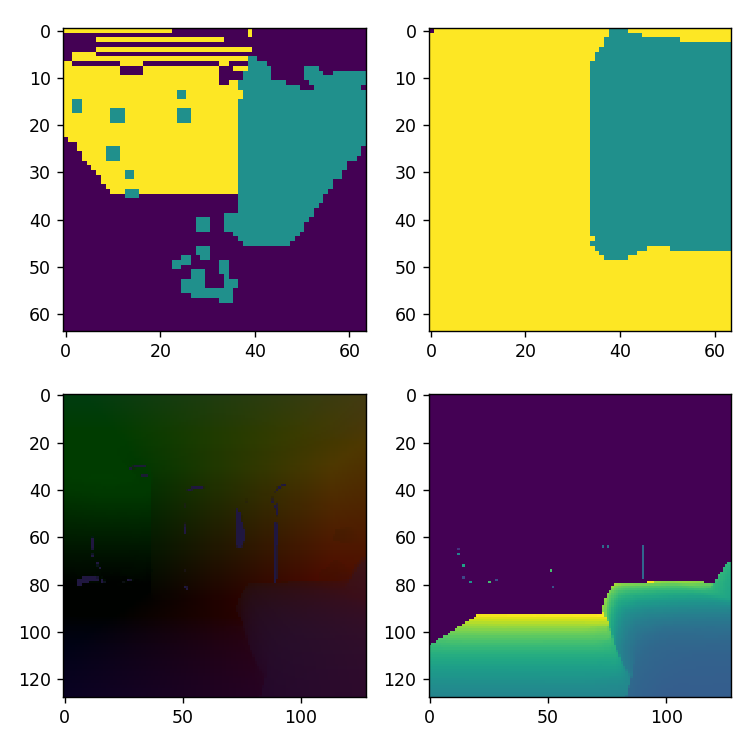

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [13]:
pred = depth_projector.get_depth_projection(depth).transpose(2, 0, 1)
pred_map = np.zeros((pred.shape[1], pred.shape[2]))
pred_map[np.logical_and(pred[1] >= 0.5, pred[0] >= 0.5)] = 1  # known and occupied
pred_map[np.logical_and(pred[1] >= 0.5, pred[0] < 0.5)] = 2  # known and free

print(np.unique(pred_map))

pred_scaled = cv2.resize(pred_map, (64,64), interpolation=cv2.INTER_NEAREST).astype(np.uint8)

comp = pred_scaled == (bev_sim // 127)

# depth_discretized = ((depth - 0.1)/0.05).astype(int)

coords = depth.reshape((*depth.shape, 1)) * cam_coords.transpose(1,2,0)
coords[:, :, 1] *= -1
coords[:, :, 2] *= -1
coords_discretized = ((coords - np.array([-1.6,-1.2,-3.2]))/0.05).astype(int)

mask = (coords_discretized[:, :, 0] >=0) & (coords_discretized[:, :, 0] < 64) & (coords_discretized[:, :, 2] >=0) & (coords_discretized[:, :, 2] < 64) & (coords_discretized[:, :, 1] >= 0) & (coords_discretized[:, :, 1] < 24)


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax = ax.flatten()
ax[0].imshow(pred_scaled, interpolation='nearest')
ax[1].imshow(bev_sim, interpolation='nearest')
ax[2].imshow(coords_discretized, interpolation='nearest')
ax[3].imshow(depth * mask, interpolation='nearest')
plt.tight_layout()

<IPython.core.display.Javascript object>


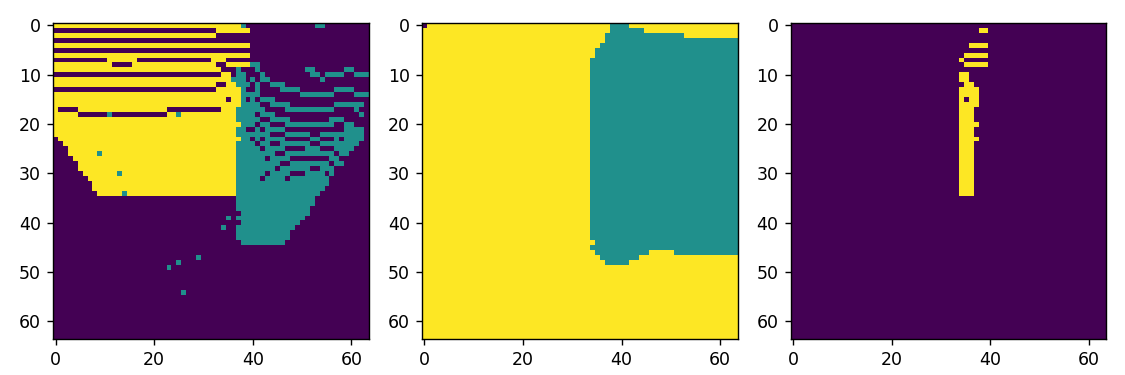

In [14]:
valid_pts = coords_discretized[mask, :]
pt_ranks = -valid_pts[:, 1] + valid_pts[:, 0] * 64 + valid_pts[:, 2] * 64 * 64

proj_bev = np.zeros((64, 64), dtype=np.uint8).reshape(-1)

ranks = np.argsort(pt_ranks)

pt_indices = valid_pts[:, 0] + valid_pts[:, 2] * 64
pt_indices = pt_indices[ranks]

valid_pts = valid_pts[ranks]

cell_max = np.hstack([[True], pt_indices[1:] != pt_indices[:-1]])

flt_pts = valid_pts[cell_max]
flt_indices = pt_indices[cell_max]

proj_bev[flt_indices] = 254 - (flt_pts[:, 1] > 2) * 127

proj_bev = proj_bev.reshape((64, 64))

comp_map = ((bev_sim != proj_bev) & (bev_sim == 127)).astype(np.uint8)
comp_map[proj_bev == 0] = 0

fig, ax = plt.subplots(ncols=3, figsize=(9, 3))
ax = ax.flatten()
ax[0].imshow(proj_bev, interpolation='nearest')
ax[1].imshow(bev_sim, interpolation='nearest')
ax[2].imshow(comp_map, interpolation='nearest')
plt.tight_layout()

<IPython.core.display.Javascript object>


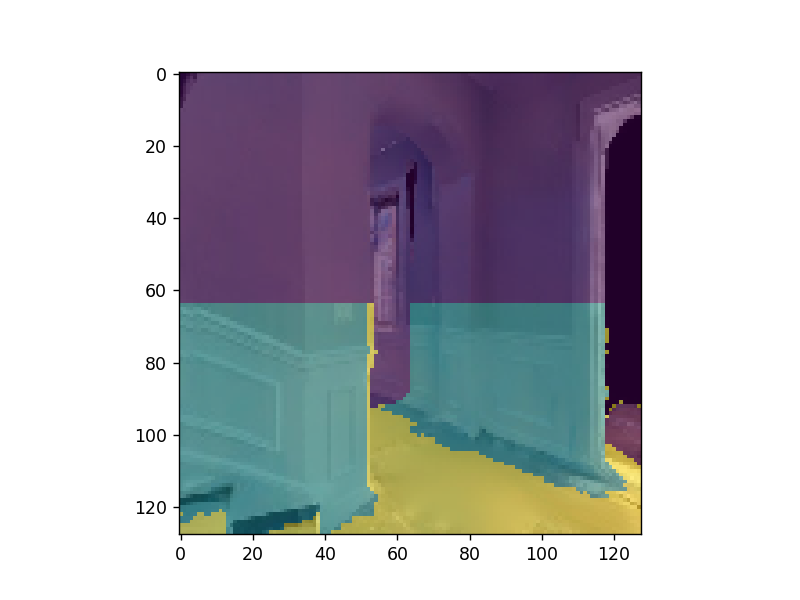

In [12]:
valid_pts = coords_discretized[mask, :]

pt_indices = valid_pts[:, 0] + valid_pts[:, 2] * 64

bev_flat = bev_sim.reshape(-1)

pt_labels = np.zeros((128, 128), dtype=np.uint8)
pt_labels[mask] = np.take(bev_flat, pt_indices)

fig = plt.figure()
ax = plt.gca()

ax.imshow(rgb)
ax.imshow(pt_labels, alpha=0.5)

plt.show()

In [15]:
pt_colors = 1 - (np.repeat(np.expand_dims(pt_labels, axis=-1), [3], axis=2)/255)
# pt_colors = rgb/255


pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(coords.reshape((-1,3)))
pcd.colors = o3d.utility.Vector3dVector(pt_colors.reshape((-1, 3)))

visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

In [16]:
visualizer.close_all()
del visualizer
del pcd

In [15]:
plt.imshow(pred[0], 'gray')

In [15]:
plt.imshow(pred[1], 'gray')

In [19]:
XYZ_ego = depth_projector.convert_to_pointcloud(depth)

# Adding agent's height to the pointcloud
XYZ_ego[:, 1] += depth_projector.camera_height

# Convert to grid coordinate system
V = depth_projector.map_size
Vby2 = V // 2

points = XYZ_ego

grid_x = (points[:, 0] / depth_projector.map_scale) + Vby2
grid_y = (points[:, 2] / depth_projector.map_scale) + V

# Filter out invalid points
valid_idx = (
    (grid_x >= 0) & (grid_x <= V - 1) & (grid_y >= 0) & (grid_y <= V - 1)
)

points = points[valid_idx, :]
grid_x = grid_x[valid_idx].astype(int)
grid_y = grid_y[valid_idx].astype(int)

# Create empty maps for the two channels
obstacle_mat = np.zeros((depth_projector.map_size, depth_projector.map_size), np.uint8)
explore_mat = np.zeros((depth_projector.map_size, depth_projector.map_size), np.uint8)

# Compute obstacle locations
high_filter_idx = points[:, 1] < depth_projector.height_thresh[1]
low_filter_idx = points[:, 1] > depth_projector.height_thresh[0]
obstacle_idx = np.logical_and(low_filter_idx, high_filter_idx)

obstacle_pts = points[obstacle_idx]

# Compute explored locations
explored_idx = high_filter_idx
explored_pts = points[high_filter_idx]

depth_projector.safe_assign(obstacle_mat, grid_y[obstacle_idx], grid_x[obstacle_idx], 1)
kernel = np.ones((3, 3), np.uint8)
# obstacle_mat = cv2.dilate(obstacle_mat, kernel, iterations=1)


depth_projector.safe_assign(explore_mat, grid_y[explored_idx], grid_x[explored_idx], 1)
kernel = np.ones((3, 3), np.uint8)
# obstacle_mat = cv2.dilate(obstacle_mat, kernel, iterations=1)

# Smoothen the maps
kernel = np.ones((3, 3), np.uint8)

# obstacle_mat = cv2.morphologyEx(obstacle_mat, cv2.MORPH_CLOSE, kernel)
# explore_mat = cv2.morphologyEx(explore_mat, cv2.MORPH_CLOSE, kernel)

explore_mat = np.logical_or(explore_mat, obstacle_mat)

<IPython.core.display.Javascript object>


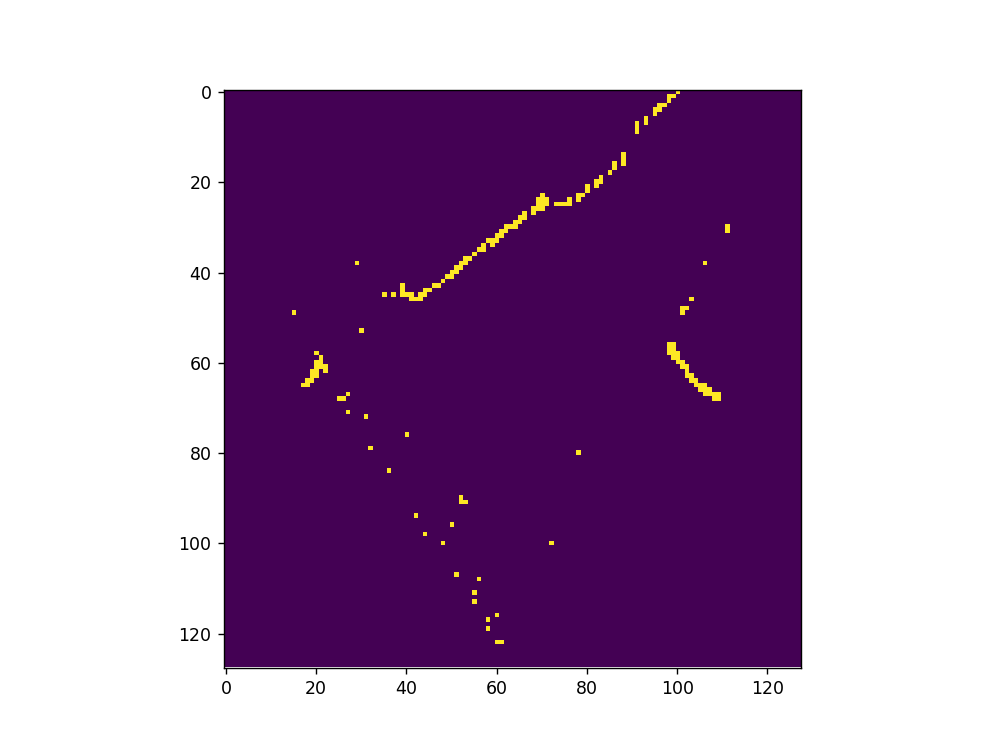

In [20]:
fig = plt.figure()
plt.imshow(obstacle_mat)

In [27]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(explored_pts)

T = np.eye(4)
T[1,1] = 1
T[2,2] = 1

pcd = pcd.transform(T)


visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

In [28]:
visualizer.close_all()
del pcd

In [28]:
np.unique(grid_y)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123])